In [1]:
%config InlineBackend.figure_format = 'svg'
import os
import string
import linecache
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate as interp

## Function to read pH, temperature, log fo2

In [2]:
def read_ph():
    
    # Find index of beginning of table
    begin = 0
    lookup = 'log fo2'
    file = open('tab', 'r', errors='ignore')
    for num, line in enumerate(file, 1):
        if lookup in line:
            begin += num
            break
    file.close()
    
    # Read headers
    top = []
    t = linecache.getline('tab', begin).strip().split('  ')
    for i, val in enumerate(t):
        if val != '':
            top.append(val.strip())
                
    begin += 2
    
    # Count number of lines
    count = 0
    while linecache.getline('tab', begin+count).strip() != '':
        count += 1
               
    # Read numerical values
    lines = []
    for i in range(begin, begin+count):
        l = linecache.getline('tab', i).strip()
        line = []
        for j in range(0, len(l), 10):
            line.append(float(l[j:j+9].strip()))
        lines.append(line)
        
    # Create table using values and headers
    tab = pd.DataFrame(data=lines, columns=top)
    # Delete unneccessary columns
    tab.drop(columns=['zi', 'time, d', 'log days', 'press', 'eh', 'pe', 'kg h2o', 'tot aff'], inplace=True)
    # Set row labels as log zi values
    tab.set_index('log zi', inplace=True)
    
    return tab

## Function to read table of solid solution product compositions

In [3]:
def read_solids():
    
    # Find index of beginning of table
    begin = 0
    lookup = 'solid solution product compositions'
    file = open('tab', 'r')
    for num, line in enumerate(file, 1):
        if lookup in line:
            begin += num
            break
    print(begin)
    file.close()

    # Find index of beginning of next table
    end = 0
    lookup = 'log of moles of product minerals'
    file = open('tab', 'r')
    for num, line in enumerate(file, 1):
        if lookup in line:
            end += num
            break
    print(end)
    file.close()
    
    # Add 2 to start index to shift from table title to first row of headers
    begin += 2
    
    tab = pd.DataFrame()
    
    size = []
    current_line = begin

    while current_line < end:
        line = linecache.getline('tab', current_line)

        if "number of solid solution product phases > 24" in line:
            # Skip this line and move forward by one
            current_line += 1
        else:
            # If the line is a header line, add it to `size`
            size.append(current_line)
            # Move to the next header line, typically incrementing by 3
            current_line += 3
    
    if(len(size) == 1):
        print("Solid solution disabled.")
        return
    
    for a, x in enumerate(size):
            
        # Read header row
        top = []
        t = linecache.getline('tab', x).strip().split('  ')
        for i, val in enumerate(t):
            if val != '':
                top.append(val.strip())
                
        # Combine multi-line species names into single string
        for p, m in enumerate(top):
            ind = linecache.getline('tab', x).index(m)
            top[p] = linecache.getline('tab', x)[ind:ind+10]+linecache.getline('tab', x+1)[ind:ind+10].strip()
            top[p] = top[p].strip()

        # Advance to read numerical values
        x += 2
        
        # Read line of values
        line = []
        l = linecache.getline('tab', x).split(' ')
        for j, v in enumerate(l):
            if v != '' and v != '\n':
                line.append(float(v))

        data = [line]

        # Add new line to existing table
        temp = pd.DataFrame(data=data, columns=top)
        tab = pd.concat([tab, temp], sort=False, ignore_index=True)
        
    # Reformat table to delete duplicates and empty rows
    tab.infer_objects()
    tab.drop_duplicates(inplace=True)

    # Track the index of the last non-NaN row in 'log zi'
    last_valid_index = None 
    
    for i, row in enumerate(tab['log zi']):
        if np.isnan(row):
            # If log zi is NaN, add non-NaN values from this row to the last valid row
            if last_valid_index is not None:
                for j, val in enumerate(tab.iloc[i]):
                    if not np.isnan(val): # Check if value is not NaN
                        tab.iloc[last_valid_index, j] = val
        else:
            #Update last_valid_index when encountering a row with a valid log zi
            last_valid_index = i
    tab.reset_index(inplace=True, drop=True)
    for i, row in enumerate(tab['log zi']):
        if np.isnan(row):
            tab.drop(i, inplace=True)
            
    # Set row labels as log zi values
    tab.set_index('log zi', inplace=True)
    
    return tab


## Function to read table of log moles of product minerals

In [4]:
def read_logmoles():
    
    # Find index of beginning of table
    begin = 0
    lookup = 'log of moles of product minerals'
    file = open('tab', 'r')
    for num, line in enumerate(file, 1):
        if lookup in line:
            begin += num
            break
    file.close()
    
    # Find index of beginning of next table
    end = 0
    lookup = 'log of destroyed moles of reactants'
    file = open('tab', 'r')
    for num, line in enumerate(file, 1):
        if lookup in line:
            end += num
            break
    file.close()
    
    # Add 5 to shift from table title to first row of headers
    begin += 5
    
    tab = pd.DataFrame()
    
    x = begin
    
    if end < (begin+9):
        print("No mineral product found.")
        return
    
    while x < end:
        
        # Read Header row
        top = []
        t = linecache.getline('tab', x).strip().split('  ')
        for i, val in enumerate(t):
            if val != '':
                top.append(val.strip())
        
        # Combine multi-line species names into single string
        for p, m in enumerate(top):
            ind = linecache.getline('tab', x).index(m)
            top[p] = linecache.getline('tab', x)[ind:ind+8]+linecache.getline('tab', x+1)[ind:ind+8]+linecache.getline('tab', x+2)[ind:ind+8].strip()
            top[p] = top[p].strip()
        
        # Advance to numerical values
        x += 4
        
        # Count number of lines under same headers
        count = 0
        while linecache.getline('tab', x+count).strip() != '':
            count += 1
        
        # Read line(s) of values
        lines = []
        for i in range(x, x+count):
            t = linecache.getline('tab', i).split(' ')
            line = []
            for j, v in enumerate(t):
                if v != '' and v != '\n':
                    line.append(float(v))
            lines.append(line)
        
        # Add new line(s) to existing table
        temp = pd.DataFrame(data=lines, columns=top)
        tab = pd.concat([tab,temp], ignore_index=True)
        
        # Advance index to next row of headers
        x += 3+count
    
    # Reformat table to delete duplicates and empty rows
    tab.infer_objects()
    tab.drop_duplicates(inplace=True)
    
    # Set row labels as log zi values
    tab.set_index('log zi', inplace=True)

    return tab

## Function to read log molality of dissolved elements

In [5]:
def read_log_elements():
    
    # Find index of beginning of table
    begin = 0
    lookup = 'log molality of dissolved elements'
    file = open('tab', 'r')
    for num, line in enumerate(file, 1):
        if lookup in line:
            begin += num
            break
    file.close()
    
    # Find index of beginning of next table
    end = 0
    lookup = 'ppm (mg/kg) of dissolved elements'
    file = open('tab', 'r')
    for num, line in enumerate(file, 1):
        if lookup in line:
            end += num
            break
    file.close()
    
    # Shift from table title to first row of headers
    begin += 2
    
    tab = pd.DataFrame()
    
    x = begin
    
    if end < (begin+5):
        print("No dissolved elements found.")
        return
    
    while x < end:
        
        # Read header row
        top = []
        t = linecache.getline('tab', x).strip().split('  ')
        for i, val in enumerate(t):
            if val != '':
                top.append(val.strip().capitalize())

        x += 2

        # Count number of numerical lines
        count = 0
        while linecache.getline('tab', x+count).strip() != '':
            count += 1
            
        # Read numerical values
        lines = []
        for i in range(x, x+count):
            t = linecache.getline('tab', i).split(' ')
            line = []
            for j, v in enumerate(t):
                if v != '' and v!= '\n':
                    line.append(float(v))
            lines.append(line)
            
        # Add values and headers to table
        temp = pd.DataFrame(data=lines, columns=top)
        # Remove unnecessary columns
        temp.drop(['Time, d', 'Log days'], axis=1, inplace=True)
        # Set row labels as log zi values
        temp.set_index('Log zi', inplace=True)
        tab = pd.concat([tab, temp], sort=False, axis=1)
            
        x += count+3
        
    # Remove H column and duplicate rows
    tab.drop(['H'], axis=1, inplace=True)
    tab.drop_duplicates(inplace=True)
        
    return tab

## Function to read log(moles) of destroyed reactants

In [6]:
def read_dest_mol():
    
    # Find index of beginning of table
    lookup = 'log of destroyed moles of reactants'
    begin = 0
    file = open('tab', 'r')
    for num, line in enumerate(file, 1):
        if lookup in line:
            begin += num
            break
    file.close()
    
    begin += 2
    
    # Read header row
    top = []
    t = linecache.getline('tab', begin).strip().split('  ')
    for i, val in enumerate(t):
        if val != '':
            top.append(val.strip())
    
    # Combine multi-line species names into single string
    for p, m in enumerate(top):
            ind = linecache.getline('tab', begin).index(m)
            top[p] = linecache.getline('tab', begin)[ind:ind+8]+linecache.getline('tab', begin+1)[ind:ind+8]+linecache.getline('tab', begin+2)[ind:ind+8].strip()
            top[p] = top[p].strip()
                
    begin += 4
    
    # Read all numerical lines
    lines = []
    while linecache.getline('tab', begin).strip() != '':
        
        t = linecache.getline('tab', begin).strip().split(' ')
        line = []
        for j, v in enumerate(t):
            if v != '' and v != '\n':
                line.append(float(v))
        lines.append(line)
        
        begin += 1

    # Add values and headers to table
    tab = pd.DataFrame(columns=top, data=lines)
    tab.drop_duplicates(inplace=True)
    # Set row labels as log zi values
    tab.set_index('log zi', inplace=True)
    
    # Return table and line number of end of table +1
    # Line number is used by the next function to find the beginning of the next table
    return tab, begin

## Function to read Created & Destroyed (cc & g) table

In [7]:
def read_dest_other():
    
    # Get index of top of table from the previous function
    begin = read_dest_mol()[1] + 3
    
    # Read header row
    top = []
    t = linecache.getline('tab', begin).strip().split('  ')
    for i, val in enumerate(t):
        if val != '':
            top.append(val.strip())
            
    begin += 2
    
    # Read numerical lines
    lines = []
    while linecache.getline('tab', begin).strip() != '':
        
        # Lines must be read in groups of 10 characters to account for lack of a ' ' between some columns
        l = linecache.getline('tab', begin).strip()
        l = ' ' + l
        line = []
        for j in range(0, len(l), 10):
            line.append(float(l[j:j+10].strip()))
        lines.append(line)
        
        begin += 1
    
    # Add values and headers to table
    tab = pd.DataFrame(columns=top, data=lines)
    tab.drop_duplicates(inplace=True)
    # Set row labels as log zi values
    tab.set_index('log zi', inplace=True)
    
    return tab

## Function to read log concentrations of species from output file

In [8]:
def read_log_conc():
    
    # List of species names to search for
    
    names = ['H2(AQ)', 'CH4(AQ)', 'HCOO-', 'CH3COO-', 'CO(AQ)', 'CO2(AQ)', 'H2CO3(AQ)', 'HCO3-', 'CO3--', 'MGSIC+', 'NAHCO3(AQ)', 'CA(HCO3)+', 'H2S(AQ)', 'HS-', 'HSO4-', 'SO4--', 'CA(HSO4)+', 'NAHSO4(AQ)', 'NA2SO4(AQ)', 'NASO4-', 'S3-'  ]
    
    # Typset chemical names for species
    #latex = ['$H_2$,aq', '$CH_4$,aq', '$HCOO^-$', '$CH_3COO^-$', '$CO$,aq', '$CO_2$,aq', '$H_2CO_3$,aq', '$HCO_3^-$', '$CO_3^{-2}$', '$H_2S$,aq', '$HS^-$', '$HSO_4^-$', '$SO_4^{-2}$', '$CA(HSO_4)^+$', '$NAHSO_4$,aq', '$NA_2SO_4$,aq', '$NASO_4^-$', '$S_3^-$']
    
    # Compile list of log zi values
    lookup = 'log of reaction progress'
    log_zi = []
    text_blocks = []
    block_lines = []
    file = open('output', 'r', errors='replace')
    for num, line in enumerate(file):
        # Save text into text_blocks
        text_blocks.append(line)
        if lookup in line:
            block_lines.append(num)
            log_zi.append(float(line.strip()[30:].strip()))
        if "no further input found" in line:
            block_lines.append(num)
    
    file.close()
    tab = pd.DataFrame(index=log_zi)

    # Read log concentration value for each species in the list
    for i, s in enumerate(names):
        vals = []
        for k in range(len(block_lines)-1):
            start = block_lines[k]
            end = block_lines[k+1]
            value = -12
            for line in text_blocks[start:end]:
                if s not in line[:20]:
                    continue
                if line.strip()[63:72].strip() != '':
                    value = float(line.strip()[63:72].strip())                    
            vals.append(max(-12, value))
        
        # If species does not have values in tables, ignore it
        if len(vals) == 0:
            continue
        # Add list of log concentrations to table
        tab[names[i]] = vals
        
    # Remove duplicates from table
    tab.drop_duplicates(inplace=True)
        
    return tab

In [9]:
def read_oxide_conc():
    
    # List of species names to search for
    
    names = ['SIO2', 'TIO2', 'AL2O3', 'CR2O3', 'FEO', 'MGO', 'CAO', 'NA2O', 'K2O', 'H2O', 'H2S']
    
    # Typset chemical names for species
    #latex = ['$H_2$,aq', '$CH_4$,aq', '$HCOO^-$', '$CH_3COO^-$', '$CO$,aq', '$CO_2$,aq', '$H_2CO_3$,aq', '$HCO_3^-$', '$CO_3^{-2}$', '$H_2S$,aq', '$HS^-$', '$HSO_4^-$', '$SO_4^{-2}$', '$CA(HSO_4)^+$', '$NAHSO_4$,aq', '$NA_2SO_4$,aq', '$NASO_4^-$', '$S_3^-$']
    
    # Compile list of log zi values
    lookup = 'log of reaction progress'
    log_zi = []
    text_blocks = []
    block_lines = []
    file = open('output', 'r', errors='replace')
    for num, line in enumerate(file):
        # Save text into text_blocks
        text_blocks.append(line)
        if lookup in line:
            block_lines.append(num)
            log_zi.append(float(line.strip()[30:].strip()))
        if "no further input found" in line:
            block_lines.append(num)
    
    file.close()
    tab = pd.DataFrame(index=log_zi)

    # Read oxide wt.% values for each oxide in the list
    for i, s in enumerate(names):
        vals = []
        for k in range(len(block_lines)-1):
            start = block_lines[k]
            end = block_lines[k+1]
            value = 0
            for line in text_blocks[start:end]:
                if s not in line[7:13]:
                    continue
                if line.strip()[12:21].strip() != '':
                    value = float(line.strip()[12:21].strip())                    
            vals.append(max(0, value))
        
        # If species does not have values in tables, ignore it
        if len(vals) == 0:
            continue
        # Add list of log concentrations to table
        tab[names[i]] = vals
        
    # Remove duplicates from table
    tab.drop_duplicates(inplace=True)
        
    return tab

In [1]:
def read_moles_dissolved():
    
    # List of species names to search for
    
    names = ['H2(AQ)', 'CH4(AQ)', 'HCOO-', 'CH3COO-', 'CO(AQ)', 'CO2(AQ)', 'H2CO3(AQ)', 'HCO3-', 'CO3--', 'H2S(AQ)', 'HS-', 'HSO4-', 'SO4--', 'CA(HSO4)+', 'NAHSO4(AQ)', 'NA2SO4(AQ)', 'NASO4-', 'S3-'  ]
    
    # Compile list of log zi values
    lookup = 'log of reaction progress'
    log_zi = []
    text_blocks = []
    block_lines = []
    file = open('output', 'r', errors='replace')
    for num, line in enumerate(file):
        # Save text into text_blocks
        text_blocks.append(line)
        if lookup in line:
            block_lines.append(num)
            log_zi.append(float(line.strip()[30:].strip()))
        if "no further input found" in line:
            block_lines.append(num)
    
    file.close()
    tab = pd.DataFrame(index=log_zi)

    # Read log concentration value for each species in the list
    for i, s in enumerate(names):
        vals = []
        for k in range(len(block_lines)-1):
            start = block_lines[k]
            end = block_lines[k+1]
            value = -12
            for line in text_blocks[start:end]:
                if s not in line[:20]:
                    continue                

                if line.strip()[21:32].strip() != '':
                    value = line.strip()[21:32].strip()
                    if 'E' in value:
                        value = float(value)
                    else:
                        index = value.index('-')
                        value = float(value[:index] + 'E' + value[index:])
                    
            vals.append(max(-12, value))
        
        # If species does not have values in tables, ignore it
        if len(vals) == 0:
            continue
        # Add list of total moles to table
        tab[names[i]] = vals
        
    # Remove duplicates from table
    tab.drop_duplicates(inplace=True)
        
    return tab

# Main

In [11]:
dirname = './Data & Plots/'
if not os.path.exists(dirname):
    os.makedirs(dirname)

# Read in the tab file
ph_tab = read_ph()
solid_tab = read_solids()
logmol_tab = read_logmoles()
log_elements_tab = read_log_elements()
dest_mol_tab = read_dest_mol()[0]
dest_other_tab = read_dest_other()

# Convert tab file information into excel file
writer = pd.ExcelWriter('%sData Tables.xlsx' %dirname)
ph_tab.to_excel(writer, 'pH, T, log fo2')
if (solid_tab is not None): solid_tab.to_excel(writer, 'Solid Solutions') 
if (logmol_tab is not None): logmol_tab.to_excel(writer, 'log(moles) Minerals')
log_elements_tab.to_excel(writer, 'log(moles) Dissolved Elements')
dest_mol_tab.to_excel(writer, 'log(moles) Destroyed')
dest_other_tab.to_excel(writer, 'Created & Destroyed (g & cc)')

# Useful only when carbon is included
log_conc_tab = read_log_conc()
log_conc_tab.to_excel(writer, 'Log Concentrations')

# New total moles of fluid species tab.. doesn't work yet
moles_dissolved_tab = read_moles_dissolved()
#moles_dissolved_tab.to_excel(writer, 'Moles fluid species')

#New oxide concentrations tab
oxide_conc_tab = read_oxide_conc()
oxide_conc_tab.to_excel(writer, 'Oxide Conc')

writer.close()

353
749


# Plot

In [12]:
def tab_plot(df, ylabel, legend, xlabel='log zi', figsize=(8,6)):
    plt.figure(figsize=figsize)
    plt.plot(df)    
    plt.legend(legend)
    plt.minorticks_on()
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.tick_params(right=True, top=True, which='both', direction='in')
    plt.tight_layout()
    plt.savefig('{}{}.pdf'.format(dirname,ylabel))
    plt.show()

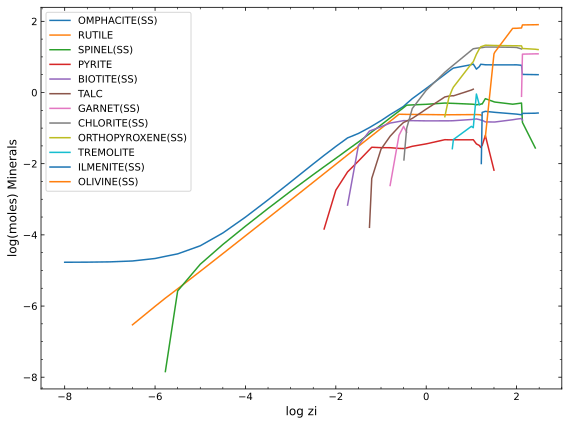

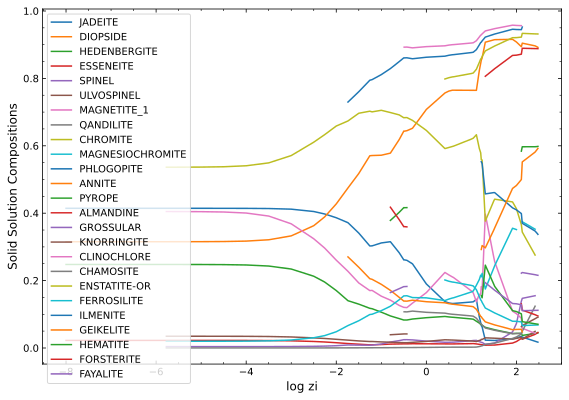

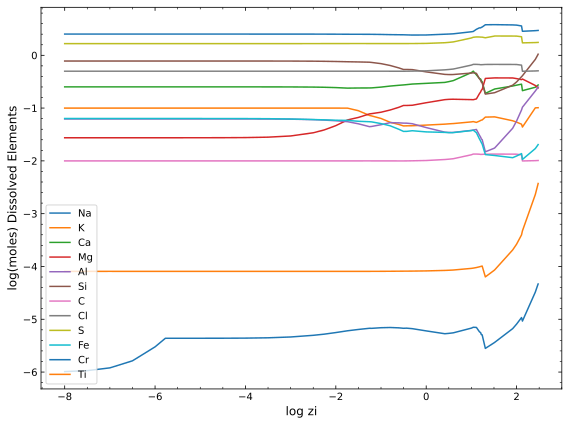

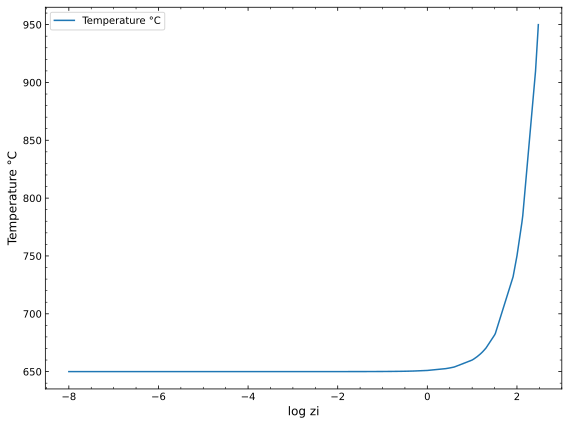

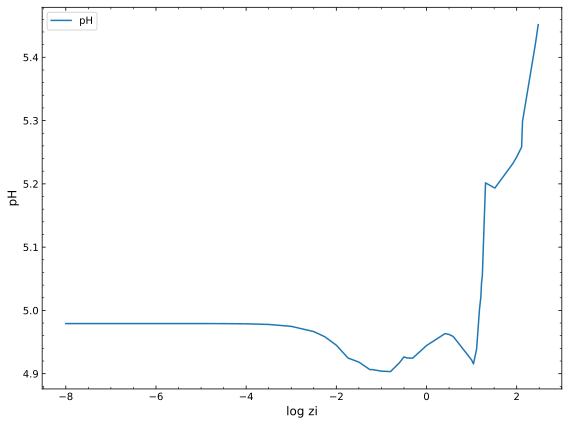

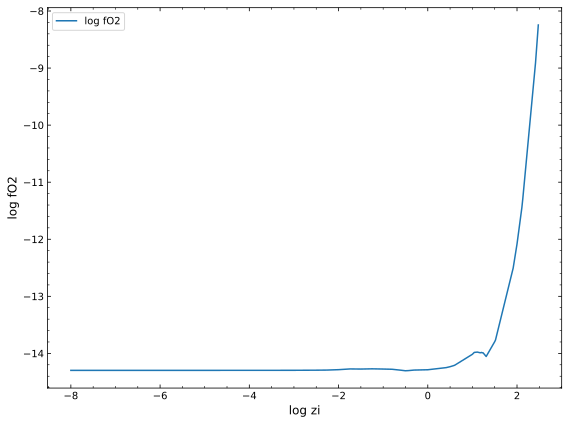

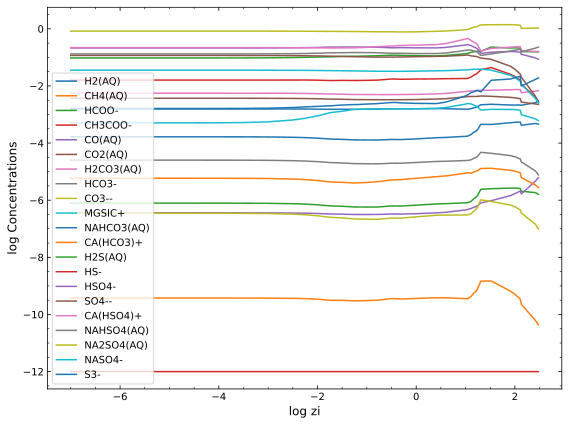

In [13]:
tab_plot(logmol_tab.iloc[1:,2:], 'log(moles) Minerals',logmol_tab.columns[2:]) if (logmol_tab is not None) else print("No mineral product data.")

tab_plot(solid_tab.iloc[1:,:], "Solid Solution Compositions", solid_tab.columns) if (solid_tab is not None) else print("Solid solution disabled.")

tab_plot(log_elements_tab.iloc[1:,:], "log(moles) Dissolved Elements", log_elements_tab.columns) if (log_elements_tab is not None) else print("No dissolved element data.")

tab_plot(ph_tab.iloc[1:,0], "Temperature °C", ['Temperature °C'])
tab_plot(ph_tab.iloc[1:,1], "pH", ['pH'])
tab_plot(ph_tab.iloc[1:,2], "log fO2", ['log fO2'])

# Useful only when carbon is included
tab_plot(log_conc_tab.iloc[1:,:], "log Concentrations", log_conc_tab.columns)

In [14]:
# plt.figure(figsize=(10,8))
# for i in range(2, len(labels)+2):
#     yval = []
#     x = []
#     for j, val in enumerate(logmol_tab.iloc[1:, i]):
#         if not np.isnan(val):
#             yval.append(val)
#             x.append(logmol_tab.index[j+1])
#     if len(x) <= 3:
#         plt.plot(x, yval)
#         continue
#     xnew = np.linspace(min(x), max(x), 100)
#     tck = interp.splrep(x, yval, s=.0001)
#     smooth = interp.splev(xnew, tck)
#     plt.plot(xnew, smooth)
# plt.legend(labels)
# plt.minorticks_on()
# plt.xlabel('log zi', fontsize=12)
# plt.ylabel('log(moles) Minerals', fontsize=12)
# plt.title('Minerals Smoothed')
# plt.tick_params(right=True, top=True, which='both', direction='in')
# plt.tight_layout()
# plt.savefig('%sMinerals Smoothed.pdf' %dirname)
# plt.show()